In [1]:
import subprocess
_output = subprocess.check_output(["maturin", "develop"])

🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.10 at /home/wint3rmute/code/luthier/.venv/bin/python
📡 Using build options features from pyproject.toml
   --> src/ladder_filter.rs:131:8
    |
131 |     fn run_ladder_nonlinear(&mut self, input: f64) {
    |        ^^^^^^^^^^^^^^^^^^^^
    |
    = note: `#[warn(dead_code)]` on by default

    Finished dev [unoptimized + debuginfo] target(s) in 0.13s
⚠️ Warning: Failed to set rpath for /home/wint3rmute/code/luthier/target/debug/libluthier.so: Failed to execute 'patchelf', did you install it? Hint: Try `pip install maturin[patchelf]` (or just `pip install patchelf`)
📦 Built wheel for CPython 3.10 to /tmp/.tmpWRdMjk/luthier-0.1.0-cp310-cp310-linux_x86_64.whl
🛠 Installed luthier-0.1.0


In [2]:
from luthier.luthier import DspGraph, SineOscillator, Multiplier, HarmonicMultiplier, Sum, ADSR, SquareOscillator, LowPassFilter, Reverb
from IPython.display import Audio, display, Image, HTML
from luthier.dsp import Sample, SAMPLE_RATE
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm.notebook import tqdm
import librosa
from scipy.optimize import differential_evolution
import numpy as np
from IPython.display import clear_output

# Sound engine presentation

- Talk about nodes
- Talk about connections (modulation)
- Outine the idea behind FM synthesis:
    - Modulation
    - Harmonics

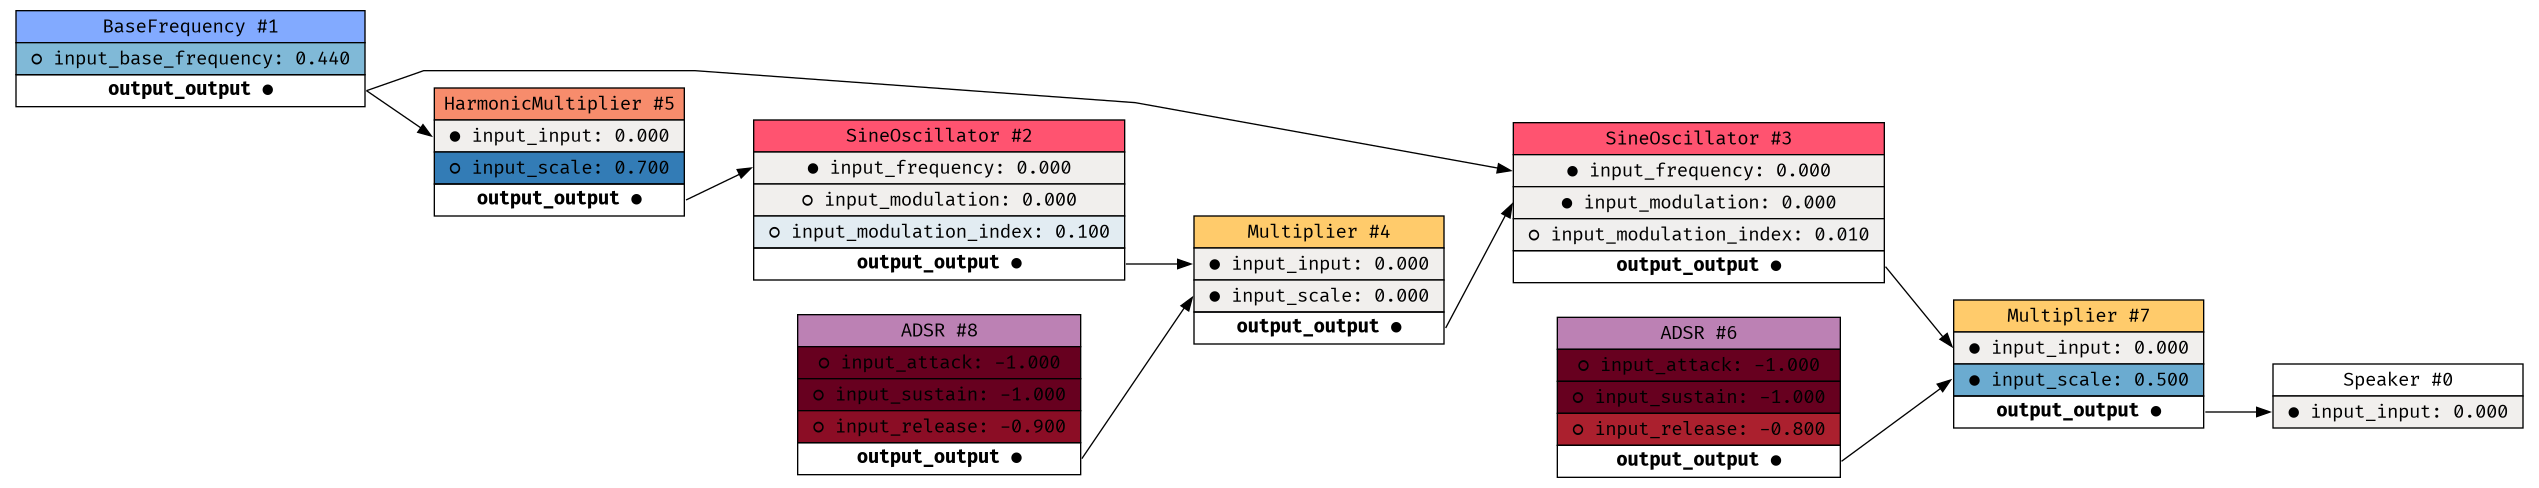

10

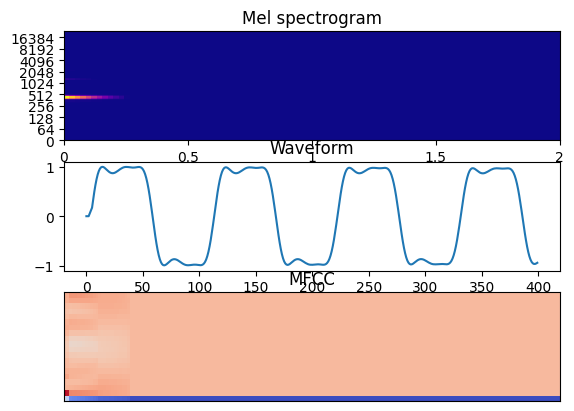

In [14]:
def one_operator_fm():
    graph = DspGraph()
    modulator = graph.add_sine(SineOscillator())
    _carrier = SineOscillator()
    carrier = graph.add_sine(_carrier)
    
    mod_index_scaler = graph.add_multiplier(Multiplier())
    mod_freq_mult = graph.add_harmonic_multiplier(HarmonicMultiplier())
    amp_adsr = graph.add_adsr(ADSR())
    amp_apply = graph.add_multiplier(Multiplier())
    
    mod_adsr = graph.add_adsr(ADSR())
    graph.patch(mod_adsr, "output_output", mod_index_scaler, "input_scale")
    
    # mod_adsr = graph.add_adsr(ADSR())
    # graph.patch(mod_adsr, "output_output", mod_index_scaler, "input_scale")
    graph.patch(amp_apply, "output_output", graph.speaker_node_id, "input_input")
    graph.patch(amp_adsr, "output_output", amp_apply, "input_scale")
    # graph.patch(
    
    graph.patch(carrier, "output_output", amp_apply, "input_input")
    graph.patch(graph.base_frequency_node_id, "output_output", carrier, "input_frequency")
    graph.patch(graph.base_frequency_node_id, "output_output", mod_freq_mult, "input_input" )
    graph.patch(mod_freq_mult, "output_output", modulator, "input_frequency")
    graph.patch(modulator, "output_output", mod_index_scaler, "input_input")
    graph.patch(mod_index_scaler, "output_output", carrier, "input_modulation")
    
    graph.set_input(4, "input_scale", 0.0 ) # mod index
    
    # graph.set_input(5, "input_scale", -0.3)
    # graph.set_input(5, "input_scale", 0.3)
    graph.set_input(5, "input_scale", 0.7)
    
    graph.set_input(3, "input_modulation_index", 0.01)

    graph.set_input(6, "input_attack", -1.0)
    graph.set_input(6, "input_sustain", -1.0)
    graph.set_input(6, "input_release", -0.8)
    
    graph.set_input(8, "input_attack", -1.0)
    graph.set_input(8, "input_sustain", -1.0)
    graph.set_input(8, "input_release", -0.9)
    
    return graph

target_graph = one_operator_fm()
display(Image(target_graph.draw()))
target_audio = Sample(target_graph.play(num_samples = SAMPLE_RATE*2))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)
target_audio.plot_spectrogram(ax1)
target_audio.plot_waveform(ax2)
target_audio.plot_mfcc(ax3)
target_audio.show_player()
target_graph.num_inputs()

# Loss function

- Describe what MFCC is and how it relates to the Fourier Transform
- Show how MFCC varies depending on the different parameter values

  0%|          | 0/41 [00:00<?, ?it/s]

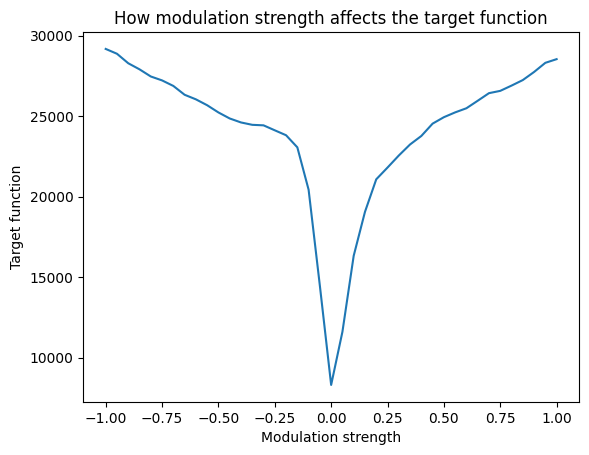

In [15]:
mod_strengths = [ a / 100 for a in range(-100, 101, 5)]

def get_distance_variable_mod_strength(strength):
    graph = one_operator_fm()
    graph.set_input(3, "input_modulation_index", strength)
    generated_audio = Sample(graph.play(SAMPLE_RATE))
    dist = target_audio.mfcc_distance(generated_audio)
    return dist

with Pool() as p:
    results = list(tqdm(p.imap(get_distance_variable_mod_strength, mod_strengths), total=len(mod_strengths)))

plt.plot(mod_strengths, results)
plt.title("How modulation strength affects the target function")
plt.xlabel("Modulation strength")
plt.ylabel("Target function")
plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

Text(0, 0.5, 'Target function')

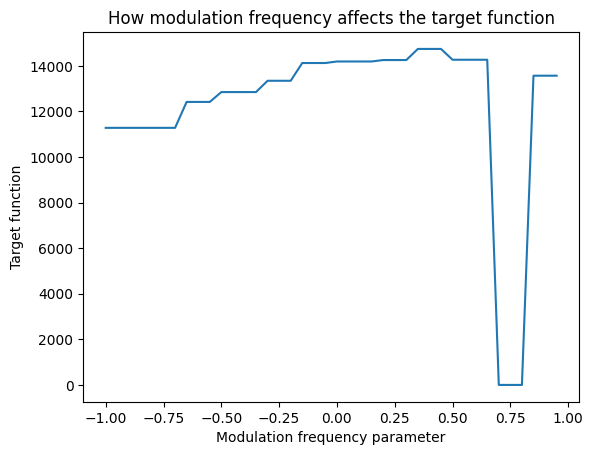

In [16]:
mod_freqs = [ a / 100 for a in range(-100, 100, 5) ]
results = []

def get_distance_variable_mod_freq(freq):
    graph = one_operator_fm()
    graph.set_input(5, "input_scale", freq)
    # graph.set_input(5, "input_scale", 1.0)
    generated_audio = Sample(graph.play(len(target_audio)))
    dist = target_audio.mfcc_distance(generated_audio)
    return dist

with Pool() as p:
    results = list(tqdm(p.imap(get_distance_variable_mod_freq, mod_freqs), total=len(mod_freqs)))

plt.plot( mod_freqs, results )
plt.title("How modulation frequency affects the target function")
plt.xlabel("Modulation frequency parameter")
plt.ylabel("Target function")

In [17]:
attack_values = [ a / 100 for a in range(-100, 100, 2) ]
results = []

def get_distance_variable_attack(attack):
    graph = one_operator_fm()
    graph.set_input(6, "input_attack", attack)
    generated_audio = Sample(graph.play(SAMPLE_RATE))
    # dist = frechet.calculate_frechet_distance(target_audio.buffer, generated_audio.buffer, 0.1, 0.1)
    dist = target_audio.mfcc_distance(generated_audio)
    return dist

with Pool() as p:
    results = list(tqdm(p.imap(get_distance_variable_attack, attack_values), total=len(attack_values)))

plt.plot(attack_values, results)
plt.title("How sound's attack envelope affects the target function")
plt.xlabel("Attack envelope parameter (closer to zero means shorter attack)")
plt.ylabel("Target function")

  0%|          | 0/100 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
STEP_VALUE = 20 # Lower means better resolution
mod_freqs = [ a / 100 for a in range(-100, 101, STEP_VALUE) ] 
mod_strengths = [ a / 100 for a in range(-100, 101, STEP_VALUE) ] 

test_cases = []
for freq_index, freq in enumerate(mod_freqs):
    for mod_index, mod_strength in enumerate(mod_strengths):    
        test_cases.append( ( (freq_index, freq), (mod_index, mod_strength) ) )

def get_distance_variable_mod_strength(test_case):
    (freq_index, freq), (mod_index, mod_strength) = test_case
    graph = one_operator_fm()

    graph.set_input(5, "input_scale", freq)
    graph.set_input(3, "input_modulation_index", mod_strength)
    generated_audio = Sample(graph.play(SAMPLE_RATE * 1))

    dist = target_audio.mfcc_distance(generated_audio)
    
    return freq_index, mod_index, dist
    
with Pool() as p:
    pool_results = list(tqdm(p.imap(get_distance_variable_mod_strength, test_cases), total=len(test_cases)))  
    
results = np.zeros((len(mod_freqs), len(mod_strengths)))

for pool_result in pool_results:
    freq_index, mod_index, dist = pool_result
    results[freq_index][mod_index] = dist
    
fig, ax = plt.subplots()
im = ax.imshow(results)

ax.set_xticks(np.arange(len(mod_strengths)), labels=mod_strengths)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_yticks(np.arange(len(mod_freqs)), labels=mod_freqs)
ax.set_ylabel("Modulation frequency")
ax.set_xlabel("Modulation strength")
plt.title("Modulation strength and modulation frequency affecting target function")
fig.tight_layout()

# Evolving DSP graph parameters

- Target function: MFCC distance
- Parameters: not modulated graph inputs
- Evolutionary algorithm - `differential_evolution`

In [ ]:
# target_audio = fm_sample

MAX_ITERATIONS = 15
POPULATION_SIZE = 60

def optimise_freq_and_mod(x):
    graph = one_operator_fm()
    graph.set_inputs(x)
    generated_audio = Sample(graph.play(len(target_audio)))
    dist = target_audio.mfcc_distance(generated_audio)
    
    return dist

def show_comparison(x):
    graph = one_operator_fm()
    graph.set_inputs(x)

    generated_audio = Sample(graph.play(num_samples = SAMPLE_RATE * 1))
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=False, sharey=False)

    generated_audio.show_player()
    target_audio.show_player()

    generated_audio.plot_spectrogram(ax1, "Trained spectrogram")
    generated_audio.plot_waveform(ax5, title="Trained waveform")
    generated_audio.plot_mfcc(ax3, title="Trained MFCC")

    target_audio.plot_spectrogram(ax2, title="Target spectrogram")
    target_audio.plot_waveform(ax6, title="Target waveform")
    target_audio.plot_mfcc(ax4, title="Target MFCC")

    fig.tight_layout()
    # plt.savefig(f'{time.time()}.png')
    plt.show()

target_fun_values = []
def callback(x, convergence):
    target_fun = optimise_freq_and_mod(x)
    target_fun_values.append(target_fun)
    clear_output()
    show_comparison(x)
    plt.plot(target_fun_values)
    plt.scatter(MAX_ITERATIONS, 0)
    plt.title(f"Training progress (problem size {len(x)})")
    plt.xlabel("Iteration number")
    plt.ylabel("MFCC distance")
    plt.show()

num_params = one_operator_fm().num_inputs()
print("Solving for num inputs", num_params)
solution = differential_evolution(
    optimise_freq_and_mod,
    [ (-1, 1) for i in range(num_params) ],
    workers=8,
    maxiter=MAX_ITERATIONS,
    popsize=POPULATION_SIZE,
    polish=False,
    disp=False,
    callback=callback
)
print(solution)

## Analog modeling

- Analog vs FM:
  - Using rich waveforms as basic oscilators
  - Subtracting frequencies using filters
- Adding a *reverb* affect to make this less boring

In [ ]:
def square_analog():
    graph = DspGraph()

    mixer = graph.add_sum(Sum())

    s = SquareOscillator()
    s.input_pwm = 0.0
    s = graph.add_square(s)

    s2 = SquareOscillator()
    s2.input_pwm = 0.3

    s2 = graph.add_square(s2)

    osc2_mult = HarmonicMultiplier()

    osc2_mult = graph.add_harmonic_multiplier(osc2_mult)

    graph.patch(graph.base_frequency_node_id, "output_output", osc2_mult, "input_input")
    graph.patch(graph.base_frequency_node_id, "output_output", s, "input_frequency")
    graph.patch(osc2_mult, "output_output", s2, "input_frequency")
    graph.patch(s2, "output_output", mixer, "input_in_2")
    graph.patch(s, "output_output", mixer, "input_in_1")

    f = LowPassFilter()
    f = graph.add_lowpass(f)

    filter_adsr = ADSR()
    filter_adsr.input_attack = 0.0
    filter_adsr.input_sustain = 0.0
    filter_adsr.input_release = 0.05
    filter_adsr = graph.add_adsr(filter_adsr)
    graph.patch(filter_adsr, "output_output",  f, "input_cutoff")

    # osc_mult = Multiplier()
    # osc_mult.input_scale = 1.0
    # osc_mult = graph.add_multiplier(osc_mult)

    r = Reverb()
    r = graph.add_reverb(r)

    graph.patch(mixer, "output_output", f, "input_input")
    graph.patch(f, "output_output", r, "input_input")
    graph.patch(r, "output_output", graph.speaker_node_id, "input_input")

    graph.set_input(f, "input_resonance", 0.5)
    
    return graph

graph = square_analog()
graph.randomize_inputs()
audio = Sample(graph.play(SAMPLE_RATE*2))
target_audio = audio
display(Image(graph.draw()))

fig, (ax, ax2) = plt.subplots(2)
audio.plot_waveform(ax)
audio.plot_spectrogram(ax2)
audio.show_player()

plt.show()

In [ ]:
target_sound = Sample(librosa.load("example_analog_pluck.wav", sr=None)[0])
target_sound.plot_sound_overview()

In [ ]:
def add_note(output, frequency, offset):
    graph = square_analog()
    graph.set_input(1, "input_base_frequency", frequency / 1000)
    
    from_index = int(offset)
    to_index = int(offset + SAMPLE_RATE*2)
    output[from_index:to_index] += graph.play(SAMPLE_RATE*2)

output = np.zeros(SAMPLE_RATE*12)

import itertools
c = itertools.count()


E6 	= 1318.51
D6s 	= 1244.51
D6 	= 1174.66
C6s 	= 1108.73
C6 	= 1046.50
B5 	= 987.77
A5s 	= 932.33
A5 	= 880.00
G5s 	= 830.61
G5 	= 783.99
F5s 	= 739.99
F5 	= 698.46
E5 	= 659.26
D5s 	= 622.25
D5 	= 587.33
C5s 	= 554.37
C5 	= 523.25
B4 	= 493.88
A4s 	= 	466.16
A4 	= 440.00
G4s 	=  	415.30
G4 	= 392.00
F4s 	= 369.99
F4 	= 349.23
E4 	= 329.63
D4s 	=  	311.13
D4 	= 293.66
C4s 	= 277.18
C4 	= 261.63

B3 	= 	246.94
A3s = 	233.08
A3 	= 	220.00
G3s = 	207.65
G3 	=	196.00
F3s = 	185.00
F3 	= 	174.61
E3 	= 	164.81
D3s = 	155.56
D3 	= 	146.83
C3s = 	138.59
C3 	= 	130.81


add_note(output, C5,   SAMPLE_RATE/7 * next(c))
add_note(output, C4,   SAMPLE_RATE/7 * next(c))
add_note(output, D5s,   SAMPLE_RATE/7 * next(c))
add_note(output, C5,   SAMPLE_RATE/7 * next(c))
add_note(output, D5,   SAMPLE_RATE/7 * next(c))
add_note(output, C5,   SAMPLE_RATE/7 * next(c))
add_note(output, D5s,   SAMPLE_RATE/7 * next(c))
add_note(output, G5,   SAMPLE_RATE/7 * next(c))

# add_note(output, C5,   SAMPLE_RATE/7 * next(c))
next(c)

add_note(output, C5,   SAMPLE_RATE/7 * next(c))
add_note(output, D5s,   SAMPLE_RATE/7 * next(c))
add_note(output, C4,   SAMPLE_RATE/7 * next(c))
add_note(output, D5,   SAMPLE_RATE/7 * next(c))
add_note(output, C4,   SAMPLE_RATE/7 * next(c))
add_note(output, D5s,   SAMPLE_RATE/7 * next(c))
add_note(output, C5,   SAMPLE_RATE/7 * next(c))

add_note(output, C5,   SAMPLE_RATE/7 * next(c))
add_note(output, C4,   SAMPLE_RATE/7 * next(c))
add_note(output, D5s,   SAMPLE_RATE/7 * next(c))
add_note(output, C5,   SAMPLE_RATE/7 * next(c))
add_note(output, D5,   SAMPLE_RATE/7 * next(c))
add_note(output, C5,   SAMPLE_RATE/7 * next(c))
add_note(output, D5s,   SAMPLE_RATE/7 * next(c))
add_note(output, G5,   SAMPLE_RATE/7 * next(c))
next(c)

add_note(output, C5,   SAMPLE_RATE/7 * next(c))
add_note(output, D5s,   SAMPLE_RATE/7 * next(c))
add_note(output, C4,   SAMPLE_RATE/7 * next(c))
add_note(output, D5,   SAMPLE_RATE/7 * next(c))
add_note(output, C4,   SAMPLE_RATE/7 * next(c))
add_note(output, D5s,   SAMPLE_RATE/7 * next(c))
add_note(output, C5,   SAMPLE_RATE/7 * next(c))

add_note(output, G4,   SAMPLE_RATE/7 * next(c))
add_note(output, G3,   SAMPLE_RATE/7 * next(c))
add_note(output, A4s,   SAMPLE_RATE/7 * next(c))
add_note(output, G3,   SAMPLE_RATE/7 * next(c))
add_note(output, A4,   SAMPLE_RATE/7 * next(c))
add_note(output, G3,   SAMPLE_RATE/7 * next(c))
add_note(output, A4s,   SAMPLE_RATE/7 * next(c))
add_note(output, D5,   SAMPLE_RATE/7 * next(c))
next(c)
add_note(output, G4,   SAMPLE_RATE/7 * next(c))
add_note(output, A4s,   SAMPLE_RATE/7 * next(c))
add_note(output, G3,   SAMPLE_RATE/7 * next(c))
add_note(output, A4,   SAMPLE_RATE/7 * next(c))
add_note(output, G4,   SAMPLE_RATE/7 * next(c))
add_note(output, A4s,   SAMPLE_RATE/7 * next(c))
add_note(output, G4,   SAMPLE_RATE/7 * next(c))

add_note(output, G4,   SAMPLE_RATE/7 * next(c))
add_note(output, G3,   SAMPLE_RATE/7 * next(c))
add_note(output, A4s,   SAMPLE_RATE/7 * next(c))
add_note(output, G3,   SAMPLE_RATE/7 * next(c))
add_note(output, A4,   SAMPLE_RATE/7 * next(c))
add_note(output, G3,   SAMPLE_RATE/7 * next(c))
add_note(output, A4s,   SAMPLE_RATE/7 * next(c))
add_note(output, D5,   SAMPLE_RATE/7 * next(c))
next(c)
add_note(output, G4,   SAMPLE_RATE/7 * next(c))
add_note(output, A4s,   SAMPLE_RATE/7 * next(c))
add_note(output, G3,   SAMPLE_RATE/7 * next(c))
add_note(output, A4,   SAMPLE_RATE/7 * next(c))
add_note(output, G4,   SAMPLE_RATE/7 * next(c))
add_note(output, A4s,   SAMPLE_RATE/7 * next(c))
add_note(output, C5,   SAMPLE_RATE/7 * next(c))



audio = Sample(output)
audio.show_player()

fix, ax = plt.subplots()
audio.plot_spectrogram(ax)

In [ ]:
# target_audio = fm_sample

MAX_ITERATIONS = 25
POPULATION_SIZE = 30

def optimise_freq_and_mod(x):
    graph = square_analog()
    graph.set_inputs(x)
    generated_audio = Sample(graph.play(len(target_audio)))
    dist = target_audio.mfcc_distance(generated_audio)
    
    return dist

def show_comparison(x):
    graph = square_analog()
    graph.set_inputs(x)

    generated_audio = Sample(graph.play(num_samples = SAMPLE_RATE * 1))
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=False, sharey=False)

    generated_audio.show_player()
    target_audio.show_player()

    generated_audio.plot_spectrogram(ax1, "Trained spectrogram")
    generated_audio.plot_waveform(ax5, title="Trained waveform")
    generated_audio.plot_mfcc(ax3, title="Trained MFCC")

    target_audio.plot_spectrogram(ax2, title="Target spectrogram")
    target_audio.plot_waveform(ax6, title="Target waveform")
    target_audio.plot_mfcc(ax4, title="Target MFCC")

    fig.tight_layout()
    # plt.savefig(f'{time.time()}.png')
    plt.show()

target_fun_values = []
def callback(x, convergence):
    target_fun = optimise_freq_and_mod(x)
    target_fun_values.append(target_fun)
    clear_output()
    show_comparison(x)
    plt.plot(target_fun_values)
    plt.scatter(MAX_ITERATIONS, 0)
    plt.title(f"Training progress (problem size {len(x)})")
    plt.xlabel("Iteration number")
    plt.ylabel("MFCC distance")
    plt.show()

num_params = square_analog().num_inputs()
print("Solving for num inputs", num_params)
solution = differential_evolution(
    optimise_freq_and_mod,
    [ (-1, 1) for i in range(num_params) ],
    workers=8,
    maxiter=MAX_ITERATIONS,
    popsize=POPULATION_SIZE,
    polish=False,
    disp=False,
    callback=callback
)
print(solution)

In [ ]:
print(123)